# MLP Models

Ok so let's bring out the big guns and try on the simple dataset

In [1]:
%pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
import pickle, os, sys
import numpy as np
from sklearn.preprocessing import StandardScaler
sys.path.append("..")
from utils import plot_mat_comp, flatten_triang, unflatten_triang, flatten_triang_batch, unflatten_triang_batch, perform_calculation, density_from_fock

2025-04-10 11:34:01.642315: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 11:34:01.642846: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 11:34:01.645374: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 11:34:01.651370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744277641.660972  157841 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744277641.66

Test and train data is generated in overlap_to_fock_first_steps and also used here!

In [25]:
with open('models/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
with open('models/train_data.pkl', 'rb') as f:
    train = pickle.load(f)
train_X = np.array([overlap for _, overlap, _, _ in train])
train_y = np.array([fock for fock, _, _, _ in train])
test_X = np.array([overlap for _, overlap, _, _ in test])
test_y = np.array([fock for fock, _, _, _ in test])
train_files = np.array([file for _, _, file, _ in train])
test_files = np.array([file for _, _, file, _ in test])
train_densities = np.array([density for _, _, _, density in train])
test_densities = np.array([density for _, _, _, density in test])


In [4]:
def summary(X): 
    print(f"shape: {X.shape}")
    print(f"dtype: {X.dtype}")
    print(f"min: {np.min(X)}")
    print(f"max: {np.max(X)}")
    print(f"mean: {np.mean(X)}")
    print(f"std: {np.std(X)}")
    print(f"median: {np.median(X)}")
    print(f"10th percentile: {np.percentile(X, 10)}")
    print(f"90th percentile: {np.percentile(X, 90)}")

In [5]:
train_X_flattened = flatten_triang_batch(train_X)
train_y_flattened = flatten_triang_batch(train_y)
test_X_flattened = flatten_triang_batch(test_X)
test_y_flattened = flatten_triang_batch(test_y)
summary(train_X_flattened)

shape: (406, 1225)
dtype: float64
min: -0.4781431157238504
max: 1.0000000000000002
mean: 0.04801266638789596
std: 0.2105067425676544
median: 5.214819106295551e-07
10th percentile: -0.02256680398828271
90th percentile: 0.10159268928878541


In [6]:
# scale data
scalerX = StandardScaler()
scalerY = StandardScaler()
train_X_scaled_flattened = scalerX.fit_transform(train_X_flattened)
train_y_scaled_flattened = scalerY.fit_transform(train_y_flattened)
test_X_scaled_flattened = scalerX.transform(test_X_flattened)
test_y_scaled_flattened = scalerY.transform(test_y_flattened)

summary(train_X_scaled_flattened)

shape: (406, 1225)
dtype: float64
min: -17.856573765025605
max: 19.763068368857272
mean: 1.9188654106118117e-18
std: 0.9454509775871028
median: 0.0
10th percentile: -0.6357438208292723
90th percentile: 0.7280575270245306


Now we only take upper triangular matrix!

In [41]:
# for now set a seed
tf.random.set_seed(42)

flattened_dim = train_X_scaled_flattened.shape[1]
inputs = tf.keras.Input(shape=(flattened_dim,))
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(flattened_dim)(x)

basic_model = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_model.compile(optimizer='adam', loss='mse', metrics=["mse", 'mae'])
# basic_model.summary()


In [42]:
basic_model.fit(train_X_scaled_flattened, train_y_scaled_flattened, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2624 - mae: 0.7643 - mse: 1.2624 - val_loss: 0.9710 - val_mae: 0.6253 - val_mse: 0.9710
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0489 - mae: 0.6705 - mse: 1.0489 - val_loss: 0.9189 - val_mae: 0.6085 - val_mse: 0.9189
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9365 - mae: 0.6241 - mse: 0.9365 - val_loss: 0.8554 - val_mae: 0.5866 - val_mse: 0.8554
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8508 - mae: 0.5951 - mse: 0.8508 - val_loss: 0.7929 - val_mae: 0.5655 - val_mse: 0.7929
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7765 - mae: 0.5738 - mse: 0.7765 - val_loss: 0.7415 - val_mae: 0.5466 - val_mse: 0.7415
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7152 - mae: 0.5551 - mse: 0.7152 - val_loss: 0.6990 - val_mae: 0.5303 - val_mse: 0.6990
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6693 - mae: 0.5424 - mse: 0.6693 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


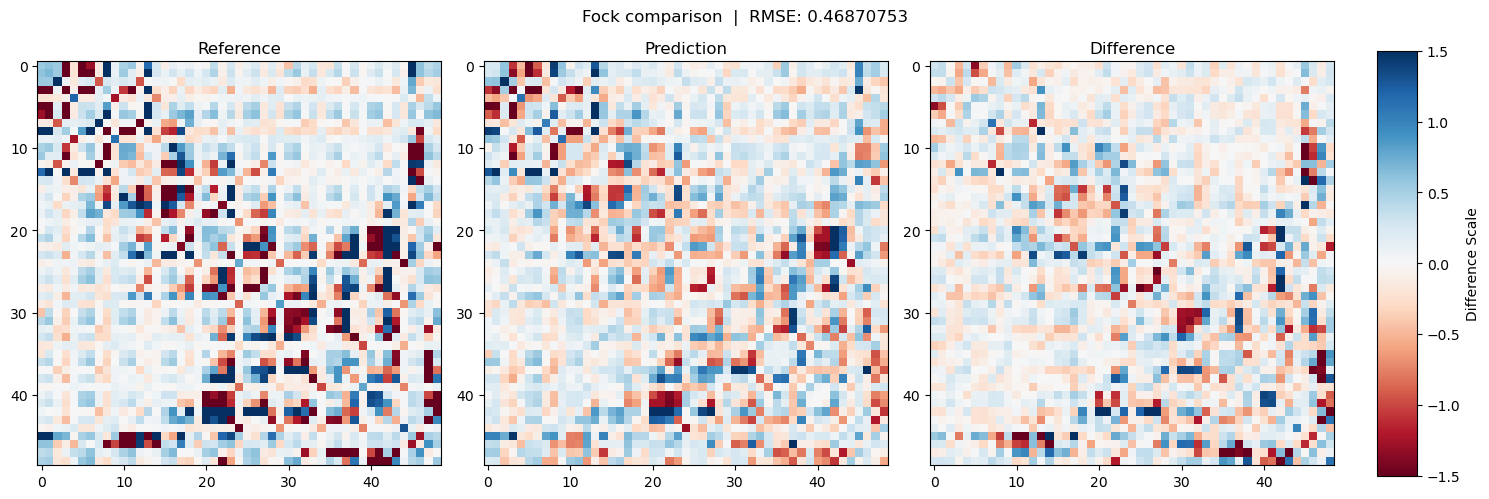

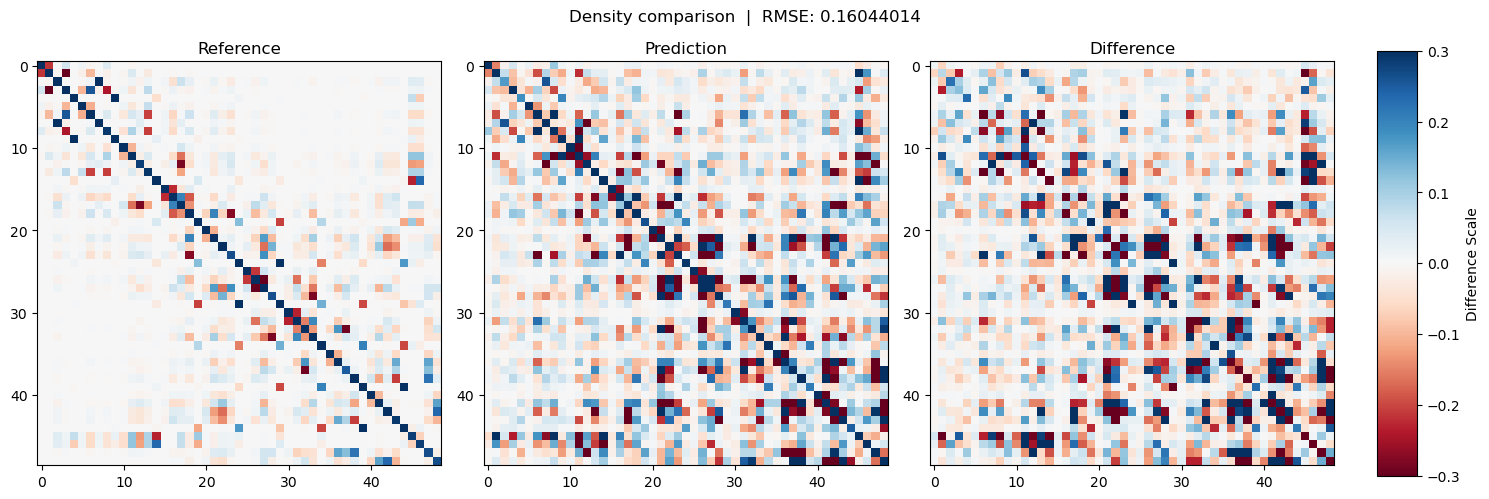

converged SCF energy = -446.896715151


{'cycles': 19,
 'conv': True,
 'summary': {'nuc': np.float64(399.37633059225425),
  'e1': np.float64(-1400.7892359132395),
  'coul': np.float64(614.0375146470851),
  'exc': np.float64(-59.521324477099945)}}

In [49]:
random_test_sample = np.random.randint(0, len(test_X_scaled_flattened))
test_file = test_files[random_test_sample]
test_ref = test_y_scaled_flattened[random_test_sample]
test_pred = basic_model.predict(test_X_scaled_flattened[random_test_sample].reshape(1, -1))
plot_mat_comp(test_ref, test_pred[0], reshape=49, title="Fock comparison")
# rescale prediciton
test_pred_rescaled = scalerY.inverse_transform(test_pred.reshape(1, -1)).reshape(-1)
test_pred_rescaled = unflatten_triang(test_pred_rescaled, 49)
density_prediction = density_from_fock(test_pred_rescaled, test_X[random_test_sample], 32)
plot_mat_comp(test_densities[random_test_sample], density_prediction, title="Density comparison", vmax=0.3)
perform_calculation(test_file, 2*density_prediction, "sto-3g", "dft", "b3lypg")
